In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import pycompo.filter as pcfilter
import pycompo.utils as pcutils

### User settings

In [2]:
# basic data settings
exp = "ngc5004"
var = "ts"
spd = 8
analysis_year = 2020
inpath = Path(
    f'/work/mh0731/m300738/project_TRR181L4/data/ngc5004_pp/{var}_latlon/'
    )

# basic analysis settings
lat_range = (-15., 15.)

# filtering settings
clim_avg_days = 30
lat_mid = 0  # degrees — adjust this based on your domain center
cutoff_scale_km = 300.
filter_truncation = 1  # filter_trunction=1 works well, otherwise to much data discarded due to islands

# sst-feature detection settings
dT_thresh = 0.2     # |SSTA| above this threshold will be detected
feature_connectivity = 8
feature_norm_type = "ellipse"
feature_min_area = 2500 # km^2
feature_props_list = [
    'centroid', 'area', 'axis_major_length', 'axis_minor_length', 'orientation',
    ]

# data_cutout_sample seettings
search_RadRatio = 3. #Data within a box with an edge length of L_maj times this factor will be extracted

### Read in data

In [3]:
# Read in data for analysis
in_pattern = f'{exp}_tropical_{var}_20200801T000000Z-20200901T000000Z.nc'
infiles = sorted([str(f) for f in inpath.rglob(in_pattern)])
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()

# Read in data for building the climatology
in_pattern  = f'{exp}_tropical_{var}_*.nc'
infiles = sorted([str(f) for f in inpath.rglob(in_pattern)])
dset_clim = xr.open_mfdataset(infiles, parallel=True).squeeze()

dset = dset.isel(time=slice(0, 2))

### Building SST anomalies
##### Infos on the filtering in degree space
Here we use a characteristic wavelength in degree since this has three advantages:
1) We remove the necessity to transform to km and can easily use a Gaussian filter
2) Ocean eddies - and thus temperature anomalies - tend to become smaller towards higher latitudes due to the Coriolis effect. Thus, cutting at a certain wavenumber instead of a certain wavelength is also physically reasonable.
3) We are in the deep tropics where the difference between longitudes and distances is small anyways.

Nevertheless, the charcateristic wavenumber has to be submitted as a characteristic wavelength at the equator -- it will be transformed internally.

In [4]:
# Detrend dataset with multiyear monthly climatology
climatology = pcfilter.build_hourly_climatology(
    dset_clim, clim_baseyear=str(analysis_year)
    )
rolling_climatology = pcutils.build_circular_rolling_avg(
    climatology, clim_avg_days, spd
    )
dset_detrend = dset - rolling_climatology
dset_detrend = dset_detrend.compute()

# Gaussian filter to extract anomalies
dset_final = pcfilter.get_gaussian_filter_bg_ano(
    dset_detrend,
    lat_mid=lat_mid, Lc_km=cutoff_scale_km, truncate=filter_truncation,
)
dset_final = dset_final.sel(lat=slice(lat_range[0], lat_range[1]), drop=True)

### Visualization

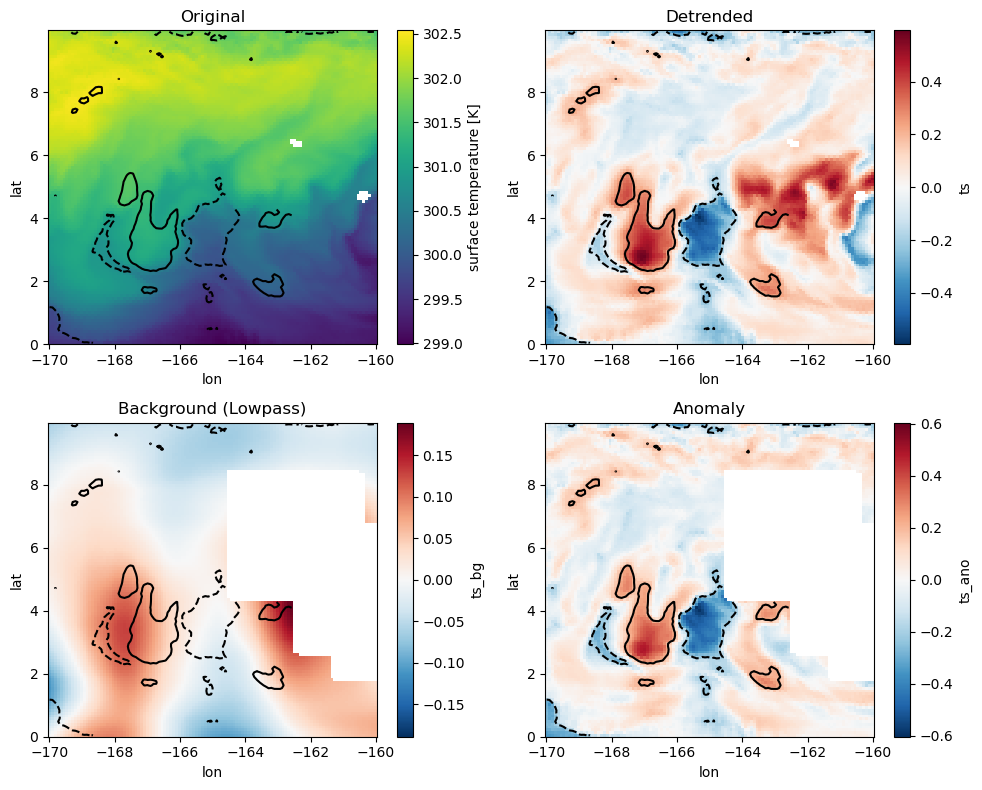

In [ ]:
lat_slice = slice(0, 10)
lon_slice = slice(-170, -160)
time_index = 0

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

dset.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)['ts'].\
    plot(ax=axs[0, 0])
axs[0, 0].set_title('Original')

dset_detrend.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)['ts'].\
    plot(ax=axs[0, 1])
axs[0, 1].set_title('Detrended')

dset_final.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)['ts_bg'].\
    plot(ax=axs[1, 0])
axs[1, 0].set_title('Background (Lowpass)')

dset_final.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)['ts_ano'].\
    plot(ax=axs[1, 1])
axs[1, 1].set_title('Anomaly')

for i in range(0, 4):
    axs.ravel()[i].contour(
        dset_final.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)['lon'],
        dset_final.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)['lat'],
        dset_final.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)['ts_ano'],
        levels=[-dT_thresh, dT_thresh], colors='k',
        )

plt.tight_layout()
plt.show()

### Detection of SST clusters

In [85]:
import pycompo.sst_features as pcsst

dset_final['sst_feature'], feature_props = pcsst.extract_sst_features(
    dset_final['ts_ano'], threshold=dT_thresh, connectivity=feature_connectivity,
    property_list=feature_props_list, feature_min_area=feature_min_area
    )

### Cut out 

In [ ]:
from typing import Tuple
import numpy as np


def get_feature_data_cartesian_centric(dset, feature_props, search_RadRatio):
    basic_coords = (dset['lat'], dset['lon'])

    feature_data = pcsst.cutout_feature_data(dset, feature_props, search_RadRatio)
    dset['sst_feature'], feature_props = update_features(
        dset['sst_feature'], feature_props, feature_data,
        )
    feature_centric_data = spherical2cartesian_featurecentric(
        basic_coords, feature_data, feature_props
        )

    return feature_data, feature_props, feature_centric_data


def update_features(
        feature_map: xr.DataArray,
        feature_props: xr.Dataset,
        feature_data: list[xr.Dataset],
        ) -> Tuple[xr.DataArray, xr.Dataset]:
    keep_features = [int(data['feature_id'].values) for data in feature_data]
    feature_props = feature_props.where(
        feature_props['feature_id'].isin(keep_features), drop=True,
        )
    feature_map = pcsst._update_feature_map(feature_map, feature_props)
    return feature_map, feature_props


def _get_centroid_coords(
        basic_coords: Tuple[xr.DataArray, xr.DataArray],
        basic_dcoords: Tuple[xr.DataArray, xr.DataArray],
        centroid_idxs: xr.DataArray
        ) -> Tuple[float, float]:
    lat = basic_coords[0]
    lon = basic_coords[1]
    dlat = basic_dcoords[0]
    dlon = basic_dcoords[1]

    centroid_exact_lat = lat[0].values + dlat*centroid_idxs[0]
    centroid_exact_lon = lon[0].values + dlon*centroid_idxs[1]

    return (float(centroid_exact_lat.values), float(centroid_exact_lon.values))


def spherical2cartesian_featurecentric(
        basic_coords: Tuple[xr.DataArray, xr.DataArray],
        feature_data_in: xr.Dataset,
        feature_props: xr.Dataset,
        ) -> list[xr.Dataset]:
    lat = basic_coords[0]
    lon = basic_coords[1]
    dlat = lat.diff('lat').mean().values
    dlon = lon.diff('lon').mean().values

    feature_data_out = []
    for idx, feature_id in enumerate(feature_props['feature_id']):
        feature = feature_props.isel(feature=idx)
        centroid_lat, centroid_lon = _get_centroid_coords(
            basic_coords, (dlat, dlon), feature['centroid_idx']
            )
        data = feature_data_in[idx]
        
        if data['lon'][0] > data['lon'][-1]:
            data['lon'] = _adjust_lon_jump(data['lon'], centroid_lon)
    
        feature_centric_lat = data['lat'] - centroid_lat
        feature_centric_lon = data['lon'] - centroid_lon
        
        feature_centric_x = feature_centric_lon * 111.195 * \
            np.cos(np.deg2rad(data['lat']))
        feature_centric_y = feature_centric_lat * 111.195
        feature_centric_y = feature_centric_y.broadcast_like(feature_centric_x)

        # Add calculated quantities to xr.Dataset that contains the feature data
        data = data.assign_coords({
            'feature_centric_lat': ('lat', feature_centric_lat.data),
            'feature_centric_lon': ('lon', feature_centric_lon.data),
        })
        data['feature_centric_x'] = feature_centric_x.transpose()
        data['feature_centric_y'] = feature_centric_y.transpose()

        feature_data_out.append(data)

    return feature_data_out


def interpolate2regular_cartesian()


def _adjust_lon_jump(
        data_lon: xr.DataArray,
        centroid_lon: float,
        ) -> xr.DataArray:
    if centroid_lon > 0:
        data_lon = xr.where(data_lon < 0, data_lon+360., data_lon)
    elif centroid_lon < 0:
        data_lon = xr.where(data_lon > 0, data_lon-360., data_lon)
    else:
        raise ValueError("Please doublecheck what's going on here!")
    return data_lon
    

In [149]:
feature_data, feature_props, feature_centric_data = get_feature_data_cartesian_centric(
    dset_final, feature_props, search_RadRatio
    )

In [150]:
feature_centric_data

<xarray.Dataset>
Dimensions:              (lat: 29, lon: 28)
Coordinates:
    time                 datetime64[ns] 2020-08-01T03:00:00
  * lat                  (lat) float64 12.31 12.4 12.49 ... 14.61 14.7 14.78
  * lon                  (lon) float64 -21.49 -21.4 -21.31 ... -19.19 -19.1
    feature_id           int64 1947
    feature_centric_lat  (lat) float64 -1.187 -1.099 -1.011 ... 1.196 1.284
    feature_centric_lon  (lon) float64 -1.159 -1.071 -0.9828 ... 1.135 1.223
Data variables:
    ts                   (lat, lon) float32 0.2965 0.3119 ... -0.5049 -0.5895
    ts_bg                (lat, lon) float32 -0.01303 -0.01179 ... nan nan
    ts_ano               (lat, lon) float32 0.3095 0.3236 0.3187 ... nan nan nan
    sst_feature          (lat, lon) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    feature_centric_x    (lat, lon) float64 -125.9 -116.4 -106.8 ... 122.0 131.5
    feature_centric_y    (lat, lon) float64 -132.0 -132.0 -132.0 ... 142.8 142.8

In [ ]:
from typing import Tuple

idx = 0
feature = 27

feature_data = dset_feature[0]
feature = feature_props.isel(cluster=0)


def add_exact_centroid_coord(lat, lon, feature_props):
    centroid_exact_coords = []
    for idx, cluster in enumerate(feature_props['cluster_id']):
        cluster_props = feature_props.isel(cluster=idx)
        centroid_exact_coords.append(
            _get_centroid_coords(
                lat, lon, cluster_props['centroid_idx']
                )
            )
    feature_props['centroid_coords'] = (
        ('cluster', 'centroid_component'), np.array(centroid_exact_coords)
    )
    return feature_props
        

feature_props = add_exact_centroid_coord(
    dset_final['lat'], dset_final['lon'], feature_props
    )

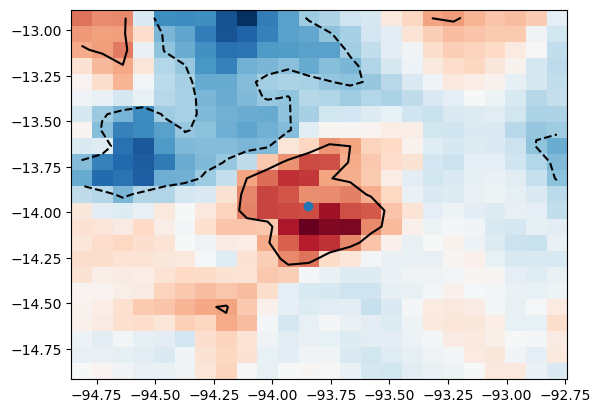

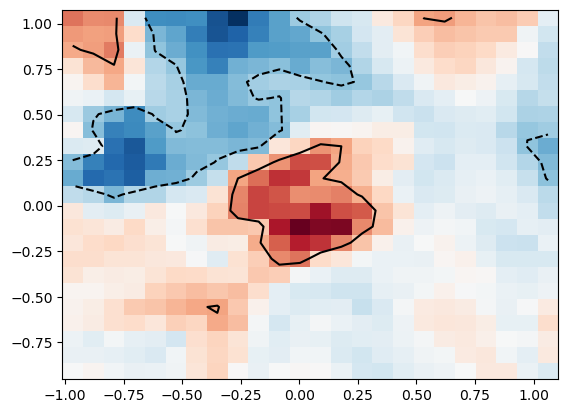

In [ ]:
plt.pcolormesh(
    feature_data['lon'], feature_data['lat'], feature_data['ts_ano'],
    cmap='RdBu_r', shading='auto'
    )
plt.contour(
    feature_data['lon'], feature_data['lat'], feature_data['ts_ano'],
    levels=[-dT_thresh, dT_thresh], colors='k',)
plt.scatter(centroid_exact_lon, centroid_exact_lat)
plt.show()


plt.pcolormesh(
    feature_centered_lon, feature_centered_lat, feature_data['ts_ano'],
    cmap='RdBu_r', shading='auto'
    )
plt.contour(
    feature_centered_lon, feature_centered_lat, feature_data['ts_ano'],
    levels=[-dT_thresh, dT_thresh], colors='k',)
#plt.scatter(centroid_exact_lon, centroid_exact_lat)
plt.show()

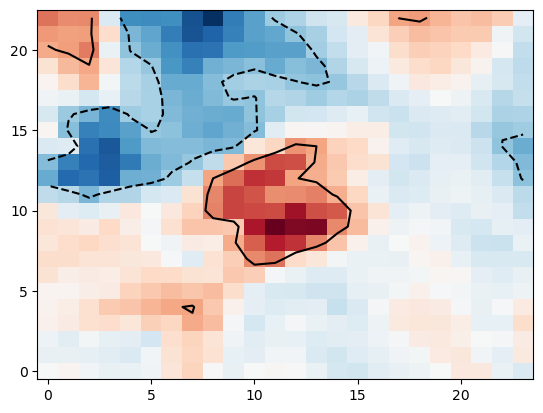

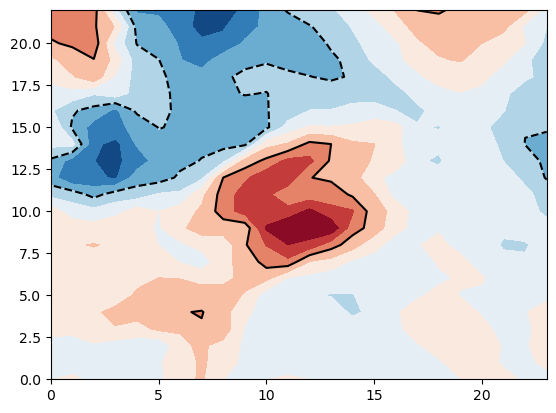

In [ ]:
plt.pcolormesh(
    np.arange(0, feature_data['lon'].shape[0]),
    np.arange(0, feature_data['lat'].shape[0]),
    feature_data['ts_ano'],
    cmap='RdBu_r', shading='auto'
    )
plt.contour(feature_data['ts_ano'], levels=[-dT_thresh, dT_thresh], colors='k',)
plt.show()

plt.contourf(feature_data['ts_ano'], cmap='RdBu_r', levels=np.arange(-0.5, 0.55, 0.1))
plt.contour(feature_data['ts_ano'], levels=[-dT_thresh, dT_thresh], colors='k',)
plt.show()

In [ ]:
feature_data['lon'].shape[0]

24

In [ ]:
# Build meshgrid of dx_km and dy_km
dlat = feature_map['lat'].diff('lat').mean().values
dlon = feature_map['lon'].diff('lon').mean().values

dx_km =


for lat_idx, lon_idx in zip(centroids_lats_idx_space, centroids_lons_idx_space):
    lat = feature_map['lat'][lat_idx]
    dx_km = dlon * (111.195 * np.cos(np.deg2rad(lat)))
    dy_km = dlat * 111.195



[1040,
 3187,
 620,
 2143,
 2964,
 976,
 2010,
 1098,
 1082,
 1071,
 837,
 3242,
 2067,
 699,
 1043,
 2675,
 994,
 966,
 1097,
 1118,
 2008,
 1874,
 2093,
 2141,
 3043,
 2771,
 2803,
 2932,
 956,
 784,
 2120,
 2064,
 2890,
 2831,
 2975,
 644,
 3046,
 640,
 1043,
 1052,
 767,
 1078,
 726,
 2058,
 2111,
 803,
 2072,
 708,
 1909,
 3123,
 3150,
 749,
 2721,
 504,
 846,
 3186,
 3969,
 2122,
 2648,
 396,
 867,
 633,
 746,
 926,
 2027,
 535,
 954,
 2526,
 409,
 2074,
 176,
 396,
 1083,
 2151,
 2920,
 993,
 532,
 3054,
 765,
 1914,
 2012,
 771,
 2736,
 2591,
 307,
 2130,
 2562,
 359,
 825,
 133,
 315,
 413,
 810,
 1980,
 934,
 983,
 2724,
 1000,
 1034,
 2529,
 1050,
 2094,
 3890,
 3923,
 3052,
 3102,
 3970,
 1075,
 213,
 227,
 903,
 176,
 385,
 2990,
 333,
 1868,
 432,
 973,
 2897,
 1795,
 27,
 407,
 457,
 1718,
 801,
 1039,
 166,
 771,
 3989,
 680,
 891,
 326,
 4078,
 809,
 2726,
 63,
 2601,
 1899,
 1853,
 588,
 3950,
 334,
 1943,
 2636,
 3873,
 141,
 2911,
 959,
 1796,
 3824,
 195,
 761,
 10

In [138]:
# Build meshgrid of dx_km and dy_km
dlat = feature_map['lat'].diff('lat').mean().values
dlon = feature_map['lon'].diff('lon').mean().values

print(dlon * (111.195 * np.cos(np.deg2rad(0))))
print(dlon * (111.195 * np.cos(np.deg2rad(15))))

9.81192475029107
9.477591521911062


### More old plotting

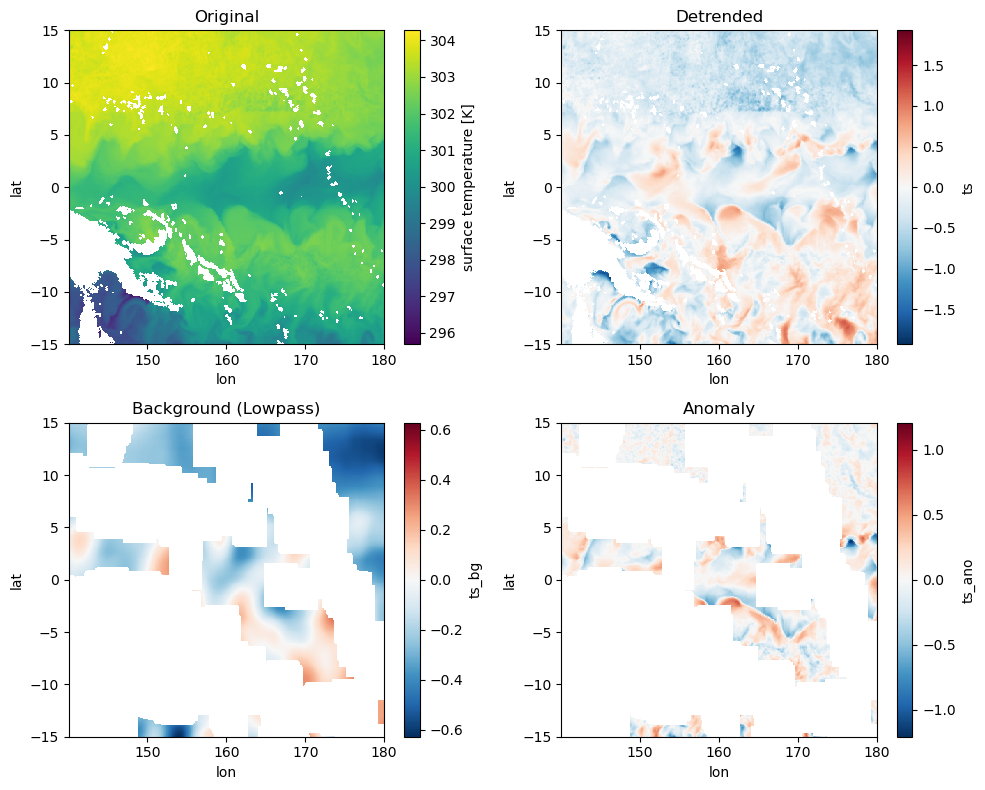

In [ ]:
lat_slice = slice(-15, 15)
lon_slice = slice(140, 180)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

dset_sample.sel(lat=lat_slice, lon=lon_slice)['ts'].plot(ax=axs[0, 0])
axs[0, 0].set_title('Original')

dset_detrend.sel(lat=lat_slice, lon=lon_slice)['ts'].plot(ax=axs[0, 1])
axs[0, 1].set_title('Detrended')

dset_final.sel(lat=lat_slice, lon=lon_slice)['ts_bg'].plot(ax=axs[1, 0])
axs[1, 0].set_title('Background (Lowpass)')

dset_final.sel(lat=lat_slice, lon=lon_slice)['ts_ano'].plot(ax=axs[1, 1])
axs[1, 1].set_title('Anomaly')

plt.tight_layout()
plt.show()


In [ ]:
def cutout_feature_data(
        data: xr.Dataset,
        feature_props: xr.Dataset
        ) -> xr.Dataset:
    
    N_lon = data.sizes['lon']

    feature_data = {}
    for idx, feature_id in enumerate(feature_props['feature_id']):
        feature = feature_props.isel(feature=idx)
        data_sample = data.sel(time=feature['time'])

        lat_lower = feature['data_bbox_idxs'].sel(cutout_idx_component='lat_lower')
        lat_upper = feature['data_bbox_idxs'].sel(cutout_idx_component='lat_upper')
        lon_left  = feature['data_bbox_idxs'].sel(cutout_idx_component='lon_left')
        lon_right = feature['data_bbox_idxs'].sel(cutout_idx_component='lon_right')

        lat_select_idxs = np.arange(lat_lower, lat_upper+1)
        
        if lon_right+1 >= N_lon:
            lon_select_idxs = np.concatenate(
                [np.arange(lon_left, N_lon), np.arange(0, (lon_right+1)-N_lon)]
                )
        else: 
            lon_select_idxs = np.arange(lon_left, lon_right+1)

        feature_data[f"feature_{feature['feature_id'].values}"] = \
            data_sample.isel(lat=lat_select_idxs, lon=lon_select_idxs)
        
    return feature_data